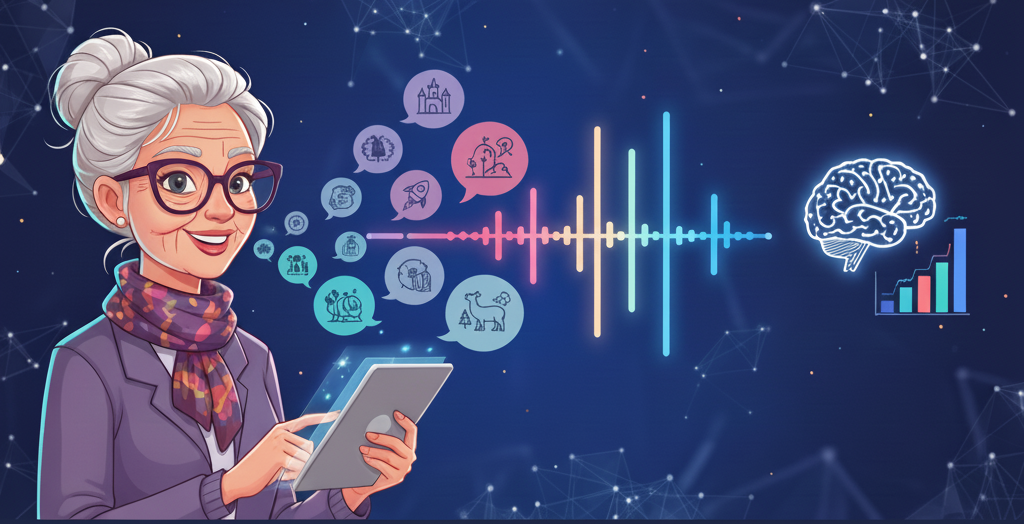

A feladat megoldásához ajánlott GPU használata, a Colab környezet alapértelmezetten ehhez fog csatlakozni.

A vasárnapi ebédet a nagymamádnál töltöd, akinek, bár isteni a főztje, van egy rossz szokása, mégpedig, hogy be nem áll a szája, megállás nélkül kitalált történeteket mesél, és felettébb sértődékeny arra, ha nem figyelnek oda rá. Az isteni ebéd (és a közben elmondott 100 történet) után - mint arra számítani lehetett - el is hangzik a kérdés:

"Na már megint hiába jártatom a számat, figyelsz te rám egyáltalán?"

Miután igazán nem szeretnéd megsérteni, igenlő választ adsz, de ezután se hagy nyugodni:

"Hát jó, ha valóban figyeltél mondd meg, hogy is kezdődött a 64. történetem!?"

Szerencsére felkészülve mindenre a telefonodon beállítottál egy automata beszéd feliratozó programot, ami már az első történettől kezdve mindent lejegyzett, amit nagymamád mondott. A gond csupán az, hogy a történetek összefolynak, valahogy meg kell találnod a 64. történet kezdetét...

A történeteket a stories.txt fileban találod. A feladatod, hogy megadd a 64. történet első 3 szavát válaszként. A szöveg történetekre való szétválogatására az alábbi módszert használjuk:
1. Szöveg szétbontása mondatokra a SpaCy segítségével
2. Mondatok embedding vektorainak előállítása a Qwen3-embedding model segítségével
3. Egymást követő mondatok szemantikai hasonlóságának vizsgálata (egy történeten belül szemantikailag hasonló mondatok vannak)
4. Szöveg történetekre bontása a beállított treshold érték alapján

Install dependencies

In [ ]:
!pip install sentence-transformers transformers torch matplotlib scipy tqdm spacy -q
!python -m spacy download en_core_web_sm

Imports

In [ ]:
import torch
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from scipy.signal import find_peaks
from tqdm.notebook import tqdm
import spacy

Load spaCy model and embedding model

In [ ]:
nlp = spacy.load("en_core_web_sm")

MODEL_NAME = 'Qwen/Qwen3-Embedding-0.6B'
embedding_model = SentenceTransformer(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model.to(device)

In [ ]:
#We give an instruction to the embedding model for better, task specific embeddings
TASK_INSTRUCTION = 'Generate an embedding for this sentence to determine if it logically follows the previous one in a story.'

def create_instructed_sentence(sentence: str) -> str:
    return f'Instruct: {TASK_INSTRUCTION}\nQuery: {sentence}'

def calculate_sentence_similarity(text: str):
    """
    Splits text into sentences using spaCy, embeds them, and calculates
    the cosine similarity between each adjacent pair of sentences.
    """
    # 1. Split the text into sentences using spaCy
    # Hint: https://spacy.io/usage/linguistic-features#sbd-parser
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]

    instructed_inputs = [create_instructed_sentence(s) for s in sentences]

    # 2. Encode all sentences into embeddings

    embeddings = embedding_model.encode(instructed_inputs, convert_to_tensor=True, show_progress_bar=True)

    # 3. Calculate cosine similarity between adjacent sentences
    cosine_scores = []
    for i in range(len(embeddings) - 1):
        similarity = util.cos_sim(embeddings[i], embeddings[i+1]).item()
        cosine_scores.append(similarity)

    return sentences, cosine_scores

In [ ]:
!gdown 198KQKd-IeCG20cOVGmC3Vac8An4WM2jw

In [ ]:
with open("stories.txt", mode="r", encoding="utf-8") as f:
  stories = f.read()

In [ ]:
sentences, scores = calculate_sentence_similarity(stories)

In [ ]:
# Choose a threshold to separate the sentences into 100 stories exactly
# We need 99 split points for 100 stories
# Sort the scores to find the 99th lowest value
sorted_scores = sorted(scores)
# Use a threshold slightly above the 99th value to ensure we get exactly 99 splits
# This handles cases where multiple scores have the same value
MANUAL_THRESHOLD = (sorted_scores[98] + sorted_scores[99]) / 2 if len(sorted_scores) > 99 else sorted_scores[98] + 0.0001

# Visualize the Scores and Threshold
plt.figure(figsize=(15, 6))
plt.plot(range(len(scores)), scores, marker='o', linestyle='-', label='Adjacent Sentence Similarity')
plt.axhline(y=MANUAL_THRESHOLD, color='red', linestyle='--', label=f'Manual Threshold ({MANUAL_THRESHOLD:.4f})')
plt.title('Semantic Similarity Between Adjacent Sentences')
plt.xlabel('Sentence Boundary Index')
plt.ylabel('Cosine Similarity Score')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
# Find the indices *after which* a split should occur.
# We add 1 because if score[i] is low, the split is after sentence i+1.
split_indices = [i + 1 for i, score in enumerate(scores) if score < MANUAL_THRESHOLD]

stories = []
start_index = 0

# Loop through the identified split points to create the stories
for split_point in split_indices:
    story_sentences = sentences[start_index:split_point]
    stories.append(" ".join(story_sentences))
    start_index = split_point

# Add the final story (from the last split point to the end of the list)
last_story_sentences = sentences[start_index:]
stories.append(" ".join(last_story_sentences))


print(f"\nDocument split into {len(stories)} stories")




In [ ]:
# Getting the first 3 letters of the 64th story
" ".join(stories[63].split(" ")[:3])